# Feature Engineering
### Examine distributions of selected features & transform features when appropriate
#### Last updated by Lindsay Warrenburg, Feb. 5, 2020

# Step 1. Set-Up
### Import packages and change working directory

In [113]:
import pandas as pd
import numpy as np
import os
import sys
import ipywidgets as widgets
import qgrid
import xlrd
import xgboost as xgb
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from collections import Counter
from random_words import RandomWords
from merf import MERF
from merf.utils import MERFDataGenerator
from merf.merf import MERF
from scipy import stats
from sklearn import preprocessing, metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from pandas.api.types import CategoricalDtype
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from plotnine import *
from plotnine.data import mpg
from IPython.display import HTML
from IPython.display import IFrame
from IPython.display import YouTubeVideo
from imblearn.over_sampling import SMOTE
%matplotlib inline

# set directory
os.chdir("/Users/home/Desktop/Data Science/Streamlit/Keep-Me-Engaged-Insight/Private")
print(os.getcwd())

files = os.listdir(os.curdir)

/Users/home/Desktop/Python/Insight/Keep-Me-Engaged


### Make View tab
#### Taken from Martin: https://stackoverflow.com/users/2575273/martin

In [114]:
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))

### Read in Data

In [115]:
data = pd.read_csv('exported_dataframeFeb2.csv')
print(data.shape, "\n")

(49346, 33) 



# Step 2. Transform Variables
### Replace Company ID Strings with Random Words from Dictionary

In [116]:
rw = RandomWords()
num_words = len(data['companyid'].unique())
print(num_words)
words = rw.random_words(letter=None, count=num_words)
print(len(words))

new_companyid = {'Id':data['companyid'].unique(),'New':words}
new_companyid = dict(zip(new_companyid['Id'], new_companyid['New']))
words = [new_companyid[Id] for Id in data['companyid']]
data['companyid_words'] = words
data[['companyid_words', 'companyid']]

631
631


### Replace Course ID Strings with Random Numbers

In [117]:
new_courseid = {ni: indi for indi, ni in enumerate(set(data['courseid']))}
numbers = [new_courseid[ni] for ni in data['courseid']]
data['courseid_num'] = numbers

### Delete Some Variables

In [118]:
# We replaced companyid and courseid above
data = data.drop(columns=['companyid', 'courseid'])

# We already filtered for completion status (previous Jupyter script)
data = data.drop(columns=['Completion Status'])

# Hours Spent on Course (average) & Course Views (average) are too correlated with our 
# DV (Engagement Score: percent of users who completed the course)
data = data.drop(columns=['Hours Spent on Course (average)', 'Course Views (average)'])

# examine
print(data.shape, "\n")
data.astype('object').describe(include='all').loc['unique', :]
View(data.head().T)

(49346, 30) 



### Visualize Courses by Category Type

courseGroup               37856
article                    9001
video                      2278
webinarCourse                87
inPersonEventCourse          56
shareableContentObject       42
course                       26
Name: Course Type, dtype: int64


/Applications/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_count : Removed 2687 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


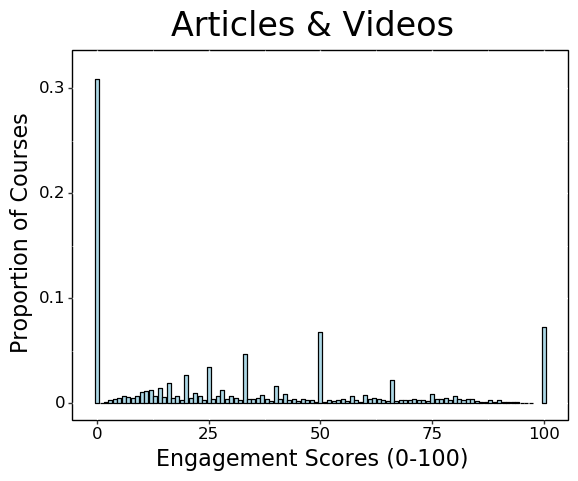

<ggplot: (7573713669)>

In [119]:
print(data['Course Type'].value_counts())

(
    ggplot(data[data['Course Type'].isin(['article', 'video'])],
        aes(x='Engagement Score')) + 
    geom_bar(mapping = aes(x = 'Engagement Score', y = "..prop..", group = 1), 
             colour = "black", fill="lightblue") +
    xlab("Engagement Scores (0-100)") + ylab("Proportion of Courses") +
    ggtitle("Articles & Videos") +
    ylim(0,0.32)+
    theme(
      axis_text_x = element_text(color = "black", size = 12, angle = 0),
      axis_text_y = element_text(color = "black", size = 12, angle = 0),
      panel_grid_major = element_line(colour = "white"),
      panel_grid_minor = element_line(colour = "white"),
      panel_background = element_rect(fill = "white"),
      strip_background = element_rect(colour="black", fill="white"),
      axis_title_y = element_text(size = 16, angle = 90),
      axis_title_x = element_text(color = "black", size = 16, angle = 0),
      plot_title = element_text(size = 24, hjust = 0.5),
      strip_text = element_text(size = 16, face = "bold"),
      plot_background = element_rect(colour = "white"),
      legend_position = "none",
      panel_border = element_rect(colour = "black", fill = "white"))
)

### Only Keep Online Courses for Evaluation 
#### (no articles, videos, webinar courses, in-person events, or shareable content objects)

In [120]:
data = data[data['Course Type'].isin(['courseGroup', 'course'])]
data = data.drop(['Course Type'], axis=1)
data.shape # (37882, 29)

# If want to use all courses in a model, here's the one-hot encoding code.
# data = pd.concat([data, pd.get_dummies(data['Course Type'], prefix='Course Type')], axis=1)

(37882, 29)

# Step 3. Dealing with Missing Values, Part 1
### Overview

In [121]:
missing = pd.DataFrame(data.isnull().sum())
View(missing)

### Delete Rows with Missing Values

In [122]:
# Engagment Score -- missing values mean there is no DV value.
data = data[np.isfinite(data['Engagement Score'])] # (46274, 36)

# Users -- missing values means there are no users in that course
data = data[np.isfinite(data['Number of Users'])]

data.shape # (37529, 29)

(37529, 29)

### Replace Missing Values with 0

In [123]:
# for these columns, an absense of a number means that it occurred 0 times 
# (e.g., if the "Average Number of Comments" is NaN, it means there were no comments)

values = {'Price (dollars)': 0, '': 0, 
          'Teacher Comments (average)': 0, 'Certificates (percent)': 0,
          'Collaborations (average)': 0, 'Discount (dollars)': 0}
data = data.fillna(value=values)

### Replace Missing Value Columns with Binary Values

In [124]:
# A NaN could also mean that the feature measured in the column hasn't been applied in the course
# e.g., there are multiple columns for SCORMs with similar amounts of missing values.
# These courses may not use SCORMs. We can replace the multiple SCORM columns with a single 
# binary column: a course DOES or DOES NOT use SCORMs.

# SCORMs
data['Uses SCORM (yes/no)'] = data['SCORM Score (average)'].notnull().astype('int')
data = data.drop(columns=['SCORM Score (average)', 'SCORM completions (percent)',
                         'Shareable SCORM (percent)', 'API SCORM (percent)'])
data['Uses SCORM (yes/no)'].value_counts()

# Milestone Course
data['Milestone Course (yes/no)'] = data['Elective Milestone (percent)'].notnull().astype('int')
data = data.drop(columns=['Elective Milestone (percent)', 'Required Milestone (percent)'])
data['Milestone Course (yes/no)'].value_counts()

0    35795
1     1734
Name: Milestone Course (yes/no), dtype: int64

# Step 4. Examine Distributions
### Get summary distribution info from all columns

In [125]:
data.describe().T

### Dependent Variable (Engagement Score)

#### Examine Distribution

In [126]:
hist(data['Engagement Score'], bins=100)
data['Engagement Score'].value_counts() # 4804 that are 100; 2037 that are 0

100.0    4804
0.0      2037
50.0     1465
40.0      932
20.0      882
         ... 
3.0       124
4.0       117
18.0      116
9.0       109
1.0       106
Name: Engagement Score, Length: 101, dtype: int64

#### Create Data for Model 1: Classification Model

In [127]:
data['Engagement Bins'] = ""
score = data.columns.get_loc("Engagement Score")
label = data.columns.get_loc("Engagement Bins")

data = data.reset_index(level=0, drop = True)

#### Create Data for Model 1: Classification Model (cont'd)

In [128]:
for i, row in data.iterrows():
    if data.iloc[i, score] == 0:
        data.iloc[i, label] = "Zero"
    if (data.iloc[i, score] > 0) & (data.iloc[i, score] < 50):
        data.iloc[i, label] = "Low"
    if (data.iloc[i, score] >= 50) & (data.iloc[i, score] < 100):
        data.iloc[i, label] = "High"
    if data.iloc[i, score] == 100:
        data.iloc[i, label] = "Hundred"

data['Engagement Bins'].value_counts()

# rearrange the categories
data['Engagement Bins'] = data['Engagement Bins'].astype('category')
bin_list = ['Zero', 'Low', 'High', 'Hundred']
bin_cat = pd.Categorical(data['Engagement Bins'], categories=bin_list)

data = data.assign(bin_cat = data['Engagement Bins'].cat.reorder_categories(bin_list))

data = data.drop(columns=['bin_cat'])

#### Plot Model 1

In [129]:
(
    ggplot(data, aes(x='Engagement Bins')) + 
    geom_bar(mapping = aes(x = 'Engagement Bins', y = "..prop..", group = 1), 
             colour = "black", fill="lightblue") +
    xlab("Engagement Scores (bins)") + ylab("Proportion of Courses") +
    ggtitle("Categorical Engagement Scores") +
    ylim(0,0.8)+
    theme(
      axis_text_x = element_text(color = "black", size = 12, angle = 0),
      axis_text_y = element_text(color = "black", size = 12, angle = 0),
      panel_grid_major = element_line(colour = "white"),
      panel_grid_minor = element_line(colour = "white"),
      panel_background = element_rect(fill = "white"),
      strip_background = element_rect(colour="black", fill="white"),
      axis_title_y = element_text(size = 16, angle = 90),
      axis_title_x = element_text(color = "black", size = 16, angle = 0),
      plot_title = element_text(size = 24, hjust = 0.5),
      strip_text = element_text(size = 16, face = "bold"),
      plot_background = element_rect(colour = "white"),
      legend_position = "none",
      panel_border = element_rect(colour = "black", fill = "white"))
)

#### Create Data for Model 2: Engagement Scores of 100 and < 100

In [1]:
#hist(data['Engagement Score'], bins=100)
data['Engagement Score'].value_counts() # 4804 that are 100

# Engagement Score -- also, we don't want 0s 
data = data[data['Engagement Score'] > 0] # (41547, 32)

hundred=data[data['Engagement Score'] == 100]
nothundred=data[data['Engagement Score'] != 100]

print("unique companies hundred:", len(hundred['companyid_words'].unique())) # 250 companies
print("unique companies not hundred:", len(nothundred['companyid_words'].unique())) # 584 companies

# print("hundred \n", hundred['Completion Status'].value_counts(), "\n")
# print("not hundred \n", nothundred['Completion Status'].value_counts(), "\n")

# print("hundred \n", hundred[['Hours Spent on Course (average)', 'Course Views (average)']].describe(), "\n")
# print("not hundred \n", nothundred[['Hours Spent on Course (average)', 'Course Views (average)']].describe(), "\n")

# print("hundred \n", hundred[['Length of Course (hours)', 'Price (dollars)']].describe(), "\n")
# print("not hundred \n", nothundred[['Length of Course (hours)', 'Price (dollars)']].describe())

data = data[(data['Engagement Score'] > 0) & (data['Engagement Score'] < 100)] 

#### Plot Model 2!

In [63]:
(
    ggplot(data,aes(x='Engagement Score')) + 
    geom_bar(mapping = aes(x = 'Engagement Score', y = "..prop..", group = 1), 
             colour = "black", fill="lightblue") +
    xlab("Engagement Scores (1-99%)") + ylab("Proportion of Courses") +
    ggtitle("Continuous Engagement Scores") +
    ylim(0,.2)+
    theme(
      axis_text_x = element_text(color = "black", size = 12, angle = 0),
      axis_text_y = element_text(color = "black", size = 12, angle = 0),
      panel_grid_major = element_line(colour = "white"),
      panel_grid_minor = element_line(colour = "white"),
      panel_background = element_rect(fill = "white"),
      strip_background = element_rect(colour="black", fill="white"),
      axis_title_y = element_text(size = 16, angle = 90),
      axis_title_x = element_text(color = "black", size = 16, angle = 0),
      plot_title = element_text(size = 24, hjust = 0.5),
      strip_text = element_text(size = 16, face = "bold"),
      plot_background = element_rect(colour = "white"),
      legend_position = "none",
      panel_border = element_rect(colour = "black", fill = "white"))
)

### Company Information
#### Plot

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


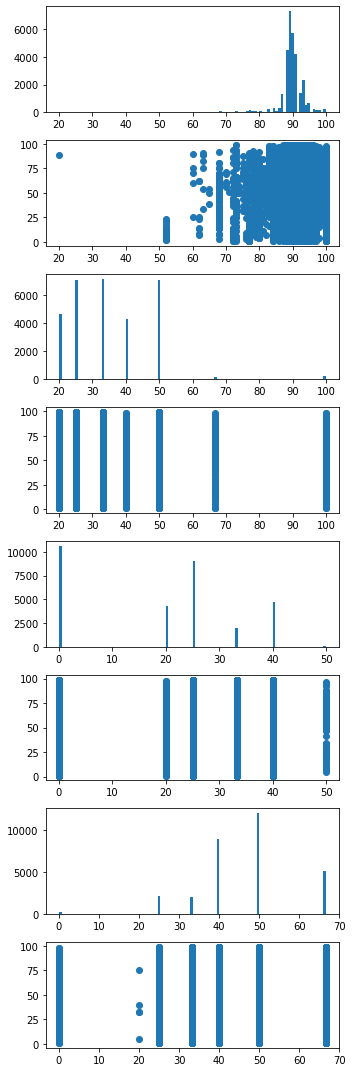

In [64]:
fig, axs = plt.subplots(8, 1, figsize=(5, 15), sharex=False, sharey=False, tight_layout=True)

axs[0].hist(data['Company Rating (average)'], bins=100)
axs[1].plot(data['Company Rating (average)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[2].hist(data['Company Administrators (percent)'], bins=100)
axs[3].plot(data['Company Administrators (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[4].hist(data['Company Instructors (percent)'], bins=100)
axs[5].plot(data['Company Instructors (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[6].hist(data['Company Learners (percent)'], bins=100)
axs[7].plot(data['Company Learners (percent)'], data['Engagement Score'], lineStyle='none', marker='o')


### Price Information

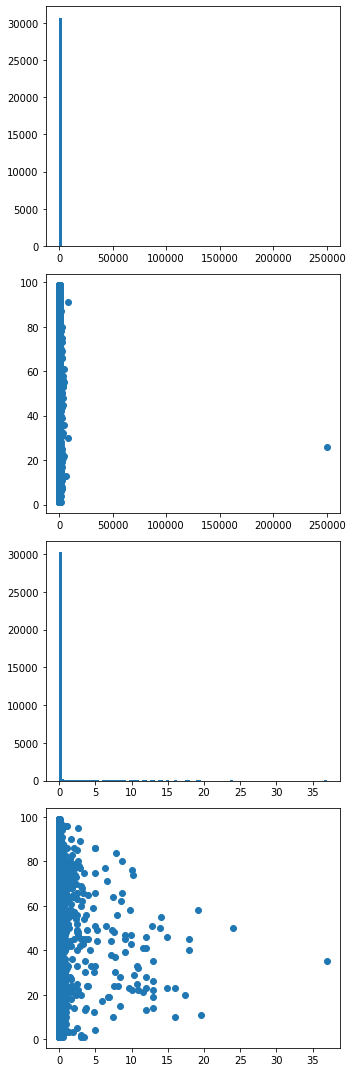

In [65]:
fig, axs = plt.subplots(4, 1, figsize=(5, 15), sharex=False, sharey=False, tight_layout=True)

axs[0].hist(data['Price (dollars)'], bins=100)
axs[1].plot(data['Price (dollars)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[2].hist(data['Discount (dollars)'], bins=100)
axs[3].plot(data['Discount (dollars)'], data['Engagement Score'], lineStyle='none', marker='o')


### Course Overview

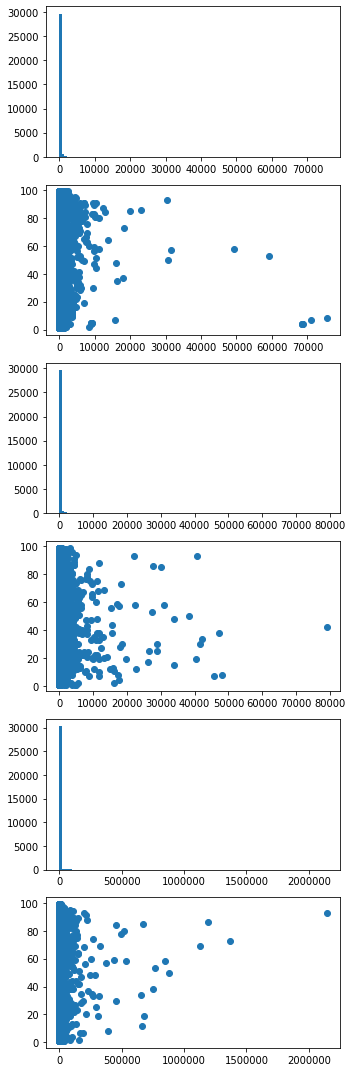

In [66]:
fig, axs = plt.subplots(6, 1, figsize=(5, 15), sharex=False, sharey=False, tight_layout=True)

axs[0].hist(data['Number of Users'], bins=100)
axs[1].plot(data['Number of Users'], data['Engagement Score'], lineStyle='none', marker='o')

axs[2].hist(data['Length of Course (hours)'], bins=100)
axs[3].plot(data['Length of Course (hours)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[4].hist(data['Visibility (# views)'], bins=100)
axs[5].plot(data['Visibility (# views)'], data['Engagement Score'], lineStyle='none', marker='o')


### Quizzes

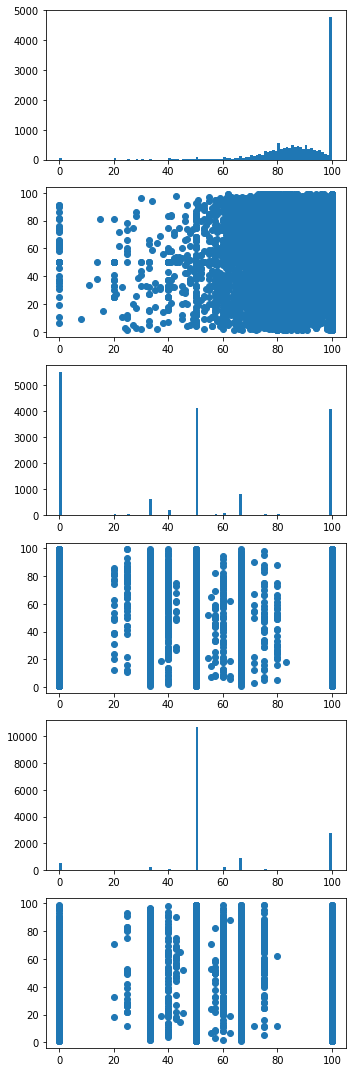

In [67]:
fig, axs = plt.subplots(6, 1, figsize=(5, 15), sharex=False, sharey=False, tight_layout=True)

axs[0].hist(data['Quiz Grade (average)'], bins=100)
axs[1].plot(data['Quiz Grade (average)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[2].hist(data['Surveys, Talleys, and Workbooks (percent)'], bins=100)
axs[3].plot(data['Surveys, Talleys, and Workbooks (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[4].hist(data['Completed Quizzes (percent)'], bins=100)
axs[5].plot(data['Completed Quizzes (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

# plot distribution with NaNs
counts = pd.DataFrame(data['Quiz Grade (average)'])
counts['Quiz Grade (average)']
counts.fillna(inplace=True, value=-10)
hist(counts['Quiz Grade (average)'], bins=100)

### Other Course Features

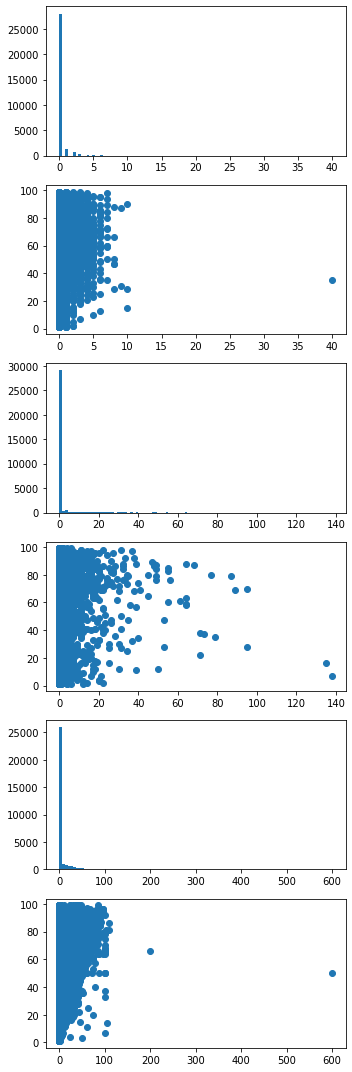

In [68]:
fig, axs = plt.subplots(6, 1, figsize=(5, 15), sharex=False, sharey=False, tight_layout=True)

axs[0].hist(data['Teacher Comments (average)'], bins=100)
axs[1].plot(data['Teacher Comments (average)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[2].hist(data['Collaborations (average)'], bins=100)
axs[3].plot(data['Collaborations (average)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[4].hist(data['Certificates (percent)'], bins=100)
axs[5].plot(data['Certificates (percent)'], data['Engagement Score'], lineStyle='none', marker='o')


### Topics

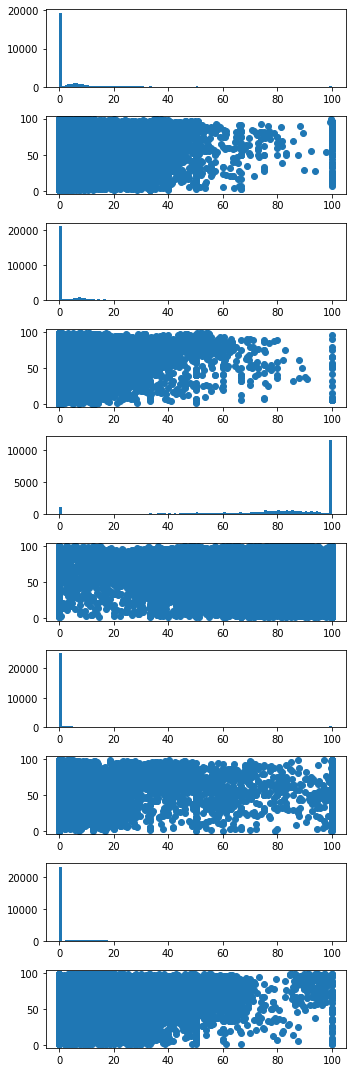

In [69]:
fig, axs = plt.subplots(10, 1, figsize=(5, 15), sharex=False, sharey=False, tight_layout=True)

axs[0].hist(data['Graded Assessment (percent)'], bins=100)
axs[1].plot(data['Graded Assessment (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[2].hist(data['Not-Graded Assessment (percent)'], bins=100)
axs[3].plot(data['Not-Graded Assessment (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[4].hist(data['Content (percent)'], bins=100)
axs[5].plot(data['Content (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[6].hist(data['External (percent)'], bins=100)
axs[7].plot(data['External (percent)'], data['Engagement Score'], lineStyle='none', marker='o')

axs[8].hist(data['Interactive (percent)'], bins=100)
axs[9].plot(data['Interactive (percent)'], data['Engagement Score'], lineStyle='none', marker='o')


# Step 5. Check for Outliers & Transform Columns
### Reset data index for outlier detection function below

In [70]:
data = data.reset_index(level=0, drop = True)

### Function to Detect Outliers 
#### from https://github.com/SayantanMitra87/Solar-Panel_Size_and_Cost_Prediction

In [71]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 3 * IQR
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )  
    return multiple_outliers   

### Check columns for outliers

In [72]:
outliers_all = detect_outliers(data,1,['Price (dollars)',
 'Length of Course (hours)',
 'Visibility (# views)',
 'Quiz Grade (average)',
 'Surveys, Talleys, and Workbooks (percent)',
 'Completed Quizzes (percent)',
 'Engagement Score',
 'Teacher Comments (average)',
 'Number of Users',
 'Certificates (percent)',
 'Collaborations (average)',
 'Discount (dollars)',
 'Graded Assessment (percent)',
 'Not-Graded Assessment (percent)',
 'Content (percent)',
 'External (percent)',
 'Interactive (percent)',
 'Company Rating (average)',
 'Company Administrators (percent)',
 'Company Instructors (percent)',
 'Company Learners (percent)'])
remove_all = data.loc[outliers_all].index
print(len(remove_all))

print("original data:", data.shape) # (41547, 32)

# remove all outliers
removeAllOutliers = data.drop(data.index[remove_all])
print("remove all outliers:", removeAllOutliers.shape) # (27568, 32)

# remove outliers from ones with really skewed distributions:
outliers_some = detect_outliers(data,1,['Company Rating (average)',
'Price (dollars)',
'Discount (dollars)',
'Number of Users',
'Length of Course (hours)',
'Visibility (# views)',
'Teacher Comments (average)',
'Collaborations (average)',
'Certificates (percent)'])
remove_some = data.loc[outliers_some].index
print(len(remove_some))

removeSomeOutliers = data.drop(data.index[remove_some])
print("remove some outliers:", removeSomeOutliers.shape) # (33154, 32)

### Apply log(1+x) to predictors with abnormal distributions

In [73]:
def log(x):
    log = np.log1p(x)
    return log

names = ['Price (dollars)',
 'Length of Course (hours)',
 'Visibility (# views)',
 'Quiz Grade (average)',
 'Surveys, Talleys, and Workbooks (percent)',
 'Completed Quizzes (percent)',
 'Engagement Score',
 'Teacher Comments (average)',
 'Number of Users',
 'Certificates (percent)',
 'Collaborations (average)',
 'Discount (dollars)',
 'Graded Assessment (percent)',
 'Not-Graded Assessment (percent)',
 'Content (percent)',
 'External (percent)',
 'Interactive (percent)',
 'Company Rating (average)',
 'Company Administrators (percent)',
 'Company Instructors (percent)',
 'Company Learners (percent)']

nonlogCols = data[['companyid_words', 'courseid_num', 
                   'Uses SCORM (yes/no)', 'Milestone Course (yes/no)',
                   'Engagement Bins']]

data_logCols = data[names].apply(log)

data_log = pd.concat([data_logCols, nonlogCols], axis=1)
print("data_log:", data_log.shape) # (30688, 25)


data_log: (30688, 26)


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Step 6. Dealing With Missing Values, Part 2
### Impute Missing Values

#### Check Columns for Missing Values

In [74]:
missing = pd.DataFrame(data.isnull().sum())
View(missing)

#### Check distributions of columns with missing values after log transformation

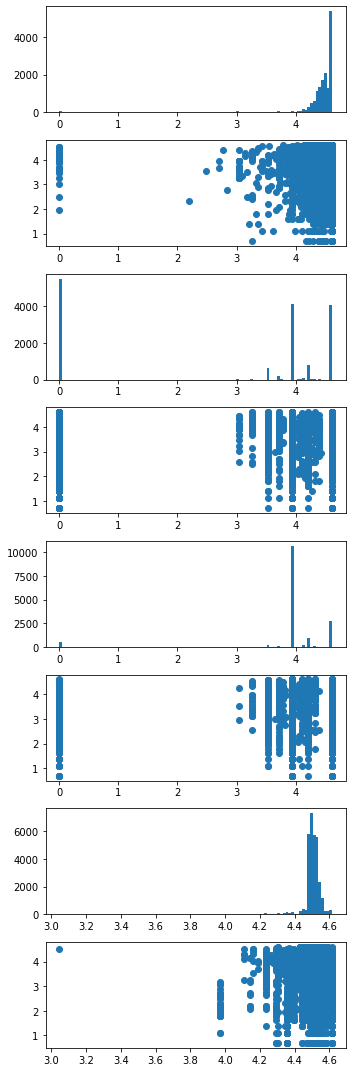

In [75]:
fig, axs = plt.subplots(8, 1, figsize=(5, 15), sharex=False, sharey=False, tight_layout=True)

axs[0].hist(data_log['Quiz Grade (average)'], bins=100)
axs[1].plot(data_log['Quiz Grade (average)'], data_log['Engagement Score'], lineStyle='none', marker='o')

axs[2].hist(data_log['Surveys, Talleys, and Workbooks (percent)'], bins=100)
axs[3].plot(data_log['Surveys, Talleys, and Workbooks (percent)'], data_log['Engagement Score'], lineStyle='none', marker='o')

axs[4].hist(data_log['Completed Quizzes (percent)'], bins=100)
axs[5].plot(data_log['Completed Quizzes (percent)'], data_log['Engagement Score'], lineStyle='none', marker='o')

axs[6].hist(data_log['Company Rating (average)'], bins=100)
axs[7].plot(data_log['Company Rating (average)'], data_log['Engagement Score'], lineStyle='none', marker='o')


#### Impute with Median

In [76]:
data = data.fillna(data.median())
data_log = data_log.fillna(data_log.median())

#### Reset Index

In [77]:
data = data.reset_index(level=0, drop = True)
data_log = data_log.reset_index(level=0, drop = True)

print("data shape:", data.shape)
print("data_log shape:", data_log.shape)

data shape: (30688, 26)
data_log shape: (30688, 26)


#### Correlation Matrices

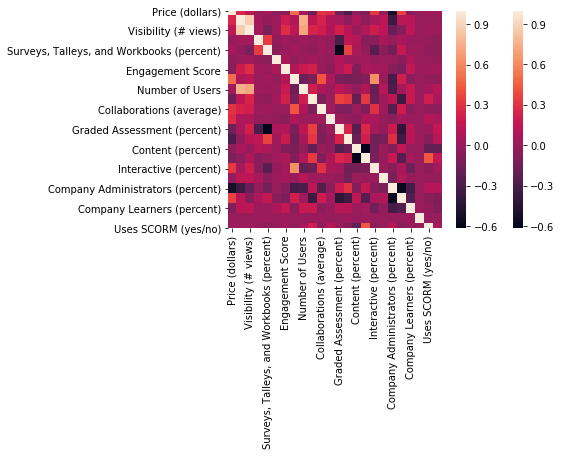

In [78]:
corrMatrix = data.corr()
corrMatrix_log = data_log.corr()
print(corrMatrix)
print(corrMatrix_log)

sns.heatmap(corrMatrix, annot=False)
sns.heatmap(corrMatrix_log, annot=False)

# Step 7. Export to CSV

In [79]:
data.to_csv(r'data.csv', index = None, header=True)
data_log.to_csv(r'data_log.csv', index = None, header=True)